L’objectif de ce TP est d'implémenter par vous même l’apprentissage de réseaux de neurones simples. Cette prise en main sera formatrice pour utiliser des frameworks plus évolués (comme PyTorch) où l’apprentissage est automatisé.

Nous allons utiliser la base de données image MNIST, constituée d’images de caractères manuscrits (60000 images en apprentissage, 10000 en test). L'objectif est de reconnaitre le chiffre par un réseau de neurones. Les images sont en niveau de gris de taille 28x28. Le vecteur d'entrée est de 784 valeurs et un vecteur de 10 valeurs en sortie.

Voici le code pour récupérer les images avec sklearn :

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.datasets import fetch_openml

In [38]:
def load_mnist_data():
  # Télécharger les données MNIST avec sklearn
  mnist = fetch_openml('mnist_784', version=1)

  # Extraire les données et les étiquettes
  X, y = mnist['data'], mnist['target']

  # Conversion en arrays numpy
  X = X.to_numpy().astype(np.float32)  # Convertir les features en float32 numpy array
  y = y.to_numpy().astype(int)         # Convertir les labels en entiers

  # Normalisation des données (optionnel)
  X /= 255.0

  # Reshape les images en 28x28 pour correspondre au format des images
  #X = X.reshape(-1, 28, 28)
  X = X.reshape(-1, 28*28)

  # Afficher les formes des arrays
  print(f'X shape: {X.shape}, y shape: {y.shape}')
  return X, y

X,Y = load_mnist_data()
print("x: type=",type(X), " shape=",np.shape(X))
print("y: type=",type(Y), " shape=",np.shape(Y))


X shape: (70000, 784), y shape: (70000,)
x: type= <class 'numpy.ndarray'>  shape= (70000, 784)
y: type= <class 'numpy.ndarray'>  shape= (70000,)


Visualisation de quelques images

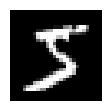

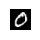

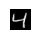

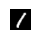

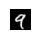

In [39]:
def visu(X_train):
  plt.figure(figsize=(28, 28))
  for i in range(5):
    plt.subplot(10,20,i+1)
    plt.imshow( 255*(X_train[i,:].reshape([28,28])), cmap='gray')
    plt.axis('off')
    plt.show()


visu(X)

Quelques fonctions utiles.

In [40]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


def sigmoid_prime(x):
    """Dérivée de la fonction sigmoid."""
    return sigmoid(x) * (1.0 - sigmoid(x))


def to_one_hot(y, k):
    """Convertit un entier en vecteur "one-hot".
    to_one_hot(5, 10) -> (0, 0, 0, 0, 1, 0, 0, 0, 0)
    """
    one_hot = np.zeros(k)
    one_hot[y] = 1
    return one_hot

La définition d'un réseau complétement connecté (FC fuly connected) est une succession de couches (layer). Un layer contient une matrice W des poids et bias : W.x_input + bias. La fonction d'activation est sigmoid.

In [41]:
class Layer:
    """
      Une seule couche de neurones.
    """
    def __init__(self, size, input_size):
      """
        `size` est le nombre de neurones dans la couche.
        `input_size` est le nombre de neurones dans la couche précédente.
      """
      self.size = size
      self.input_size = input_size

      # Les poids sont représentés par une matrice de n lignes et m colonnes.
      # n = le nombre de neurones, m = le nombre de neurones dans la couche précédente.
      self.weights = np.random.randn(size, input_size)

      # Un biais par neurone: y = W.x + B (B=bias)
      self.bias = np.random.randn(size)


    def forward(self, data):
      """
        Résultat du calcul de chaque neurone.
        `data` est un vecteur de longueur `self.input_size`
        retourne un vecteur de taille `self.size`.
      """
      aggregation = self.aggregation(data)
      activation = self.activation(aggregation)
      return activation


    def aggregation(self, data):
      """
        Calcule W.data + bias
      """
      return np.dot(self.weights, data) + self.bias


    def activation(self, x):
        """
          Passe les valeurs aggrégées dans la fonction d'activation.
        """
        return sigmoid(x)


    def activation_prime(self, x):
        return sigmoid_prime(x)


    def update_weights(self, gradient, learning_rate):
        """ Mise à jour des poids à partir du gradient (algo du gradient) """
        self.weights -= learning_rate * gradient


    def update_biases(self, gradient, learning_rate):
        """ Idem mais avec les biais """
        self.bias -= learning_rate * gradient

Le réseau

In [45]:
class Network:
    """Un réseau constitué de couches de neurones."""
    def __init__(self, input_dim):
        self.input_dim = input_dim
        self.layers = []


    def add_layer(self, size):
        if len(self.layers) > 0:
            input_dim = self.layers[-1].size
        else:
            input_dim = self.input_dim
        self.layers.append(Layer(size, input_dim))


    def feedforward(self, input_data):
        """ Propage les données d'entrée d'une couche à l'autre """
        activation = input_data
        for layer in self.layers:
            activation = layer.forward(activation)
        return activation


    def predict(self, input_data):
        """ Passe input_data dans le réseau (feedForward) et retourne l'index du neurone de 
            sortie qui a la plus grande valeur (qui est la classe sélectionnée par le réseau). """
        return np.argmax(self.feedforward(input_data))


    def evaluate(self, X, Y):
        """ Évalue la performance du réseau à partir d'un set d'exemples. Retourne un nombre entre 0 et 1."""
        results = 0.0
        n = 0
        for (x,y) in zip(X,Y):
            results += (self.predict(x.reshape( 28*28 )  ) == y)
            n += 1
        #results = [1 if self.predict(x) == y else 0 for (x, y) in zip(X, Y)]
        accuracy = results / n
        return accuracy


    def train(self, X, Y, steps=30, learning_rate=0.3, batch_size=10):
        """
            Fonction d'entraînement du modèle.
            La rétropropagation tourne sur un certain nombre d'exemples (batch_size) avant 
            de calculer un gradient moyen, et de mettre à jour les poids.
        """
        n = Y.size
        for i in range(steps):
            X, Y = shuffle(X, Y)
            for batch_start in range(0, n, batch_size):
                X_batch, Y_batch = X[batch_start:batch_start + batch_size], Y[batch_start:batch_start + batch_size]
                self.train_batch(X_batch, Y_batch, learning_rate)


    def train_batch(self, X, Y, learning_rate):
        """     Cette fonction combine les algos du retropropagation du gradient + gradient descendant """
        # Initialise les gradients pour les poids et les biais.
        weight_gradient = [np.zeros(layer.weights.shape) for layer in self.layers]
        bias_gradient = [np.zeros(layer.bias.shape) for layer in self.layers]

        # On fait tourner l'algo de rétropropagation pour calculer les
        # gradients un certain nombre de fois. On fera la moyenne ensuite.
        for (x, y) in zip(X, Y):
            new_weight_gradient, new_bias_gradient = self.backprop(x, y)
            weight_gradient = [wg + nwg for wg, nwg in zip(weight_gradient, new_weight_gradient)]
            bias_gradient = [bg + nbg for bg, nbg in zip(bias_gradient, new_bias_gradient)]

        # C'est ici qu'on calcule les moyennes des gradients calculés
        avg_weight_gradient = [wg / Y.size for wg in weight_gradient]
        avg_bias_gradient = [bg / Y.size for bg in bias_gradient]

        # Il ne reste plus qu'à mettre à jour les poids et biais en utilisant l'algo du gradient descendant.
        for layer, weight_gradient, bias_gradient in zip(self.layers, avg_weight_gradient, avg_bias_gradient):
            layer.update_weights(weight_gradient, learning_rate)
            layer.update_biases(bias_gradient, learning_rate)


    def backprop(self, x, y):
        """   L'algorithme de rétropropagation du gradient. C'est là que tout le boulot se fait. """
        # Une passe vers l'avant puis une passe vers l'arrière
        # On profite de la passe vers l'avant pour stocker les calculs
        # intermédiaires, qui seront réutilisés par la suite.
        aggregations = []
        activation = x
        activations = [activation]

        # Propagation pour obtenir la sortie (même code que feedForward mais on stocke les valeurs intermédiaires dans aggregations et activations)
        for layer in self.layers:
            aggregation = layer.aggregation(activation)
            aggregations.append(aggregation)
            activation = layer.activation(aggregation)
            activations.append(activation)

        # Calcul de delta pour la dernière couche (delta = erreur)
        target = to_one_hot(int(y), 10)
        delta = self.get_output_delta(aggregation, activation, target)
        deltas = [delta]

        # Phase de rétropropagation pour calculer les deltas de chaque couche
        # On utilise une implémentation vectorielle des équations.
        nb_layers = len(self.layers)
        for l in reversed(range(nb_layers - 1)):
            layer = self.layers[l]
            next_layer = self.layers[l + 1]
            activation_prime = layer.activation_prime(aggregations[l])
            delta = activation_prime * np.dot(next_layer.weights.transpose(), delta)
            deltas.append(delta)

        # Départ de l'avant-dernière couche pour remonter vers la première. 
        # deltas[0] contient le delta de la dernière couche.
        # Il faut inverser pour faciliter la gestion des indices plus tard.
        deltas = list(reversed(deltas))

        # On utilise maintenant les deltas pour calculer les gradients.
        weight_gradient = []
        bias_gradient = []
        for l in range(len(self.layers)):
            # L'indice des activations est « décalé », puisque
            # activation[0] contient l'entrée (x), et pas l'activation de la première couche.
            prev_activation = activations[l]
            weight_gradient.append(np.outer(deltas[l], prev_activation))
            bias_gradient.append(deltas[l])
        return weight_gradient, bias_gradient

    # Calcule le delta pour la dernière couche, en utilisant
    # les dernières valeurs d'aggregation, d'activation, et la valeur cible.
    # Notez que lorsque l'on utilise l'entropie croisée pour fonction de
    # coût, l'équation de calcul de delta peut-être simplifiée pour aboutir
    # au résultat ci dessous.
    # Cf http://neuralnetworksanddeeplearning.com/chap3.html#the_cross-entropy_cost_function
    def get_output_delta(self, computed, target):
        return computed - target

Le main

In [46]:
# La base de données est coupée en deux : entraînement et test.
# X, Y = load_mnist_data()      # déjà chargée avant
X_train, Y_train = X[:60000], Y[:60000]
X_test, Y_test = X[60000:], Y[60000:]

net = Network(input_dim=784)
net.add_layer(200)
net.add_layer(10)

accuracy = net.evaluate(X_test, Y_test)
print('Performance initiale : {:.2f}%'.format(accuracy * 100.0))

for i in range(5):
    net.train(X_train, Y_train, steps=1, learning_rate=3.0)
    accuracy = net.evaluate(X_test, Y_test)
    print('Nouvelle performance : {:.2f}%'.format(accuracy * 100.0))

Performance initiale : 8.55%
Nouvelle performance : 93.30%


KeyboardInterrupt: 